## LSTM (Long Short Term Memory networks)
- 기존의 RNN은 거리가 먼 데이터를 사용하여 학습할 수 없음. 거리가 멀어질수록 그 정보의 연결 방법을 배울 수 없음
- LSTM은 RNN과 달리 하나의 신경망 층 대신 네 개의 상호작용하는 층 포함
    - 데이터의 long-term dependency를 학습하는 데 효과적
- 이 코드를 통해 LSTM을 학습하기 위해 어떠한 데이터 구조(input, output 형태)가 필요한지, 네트워크 구조를 코드 상으로 어떻게 정의하는지 살펴봄
- [출처](https://3months.tistory.com/168)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("datasets/data.csv", skiprows=6, skipfooter=9, engine="python")
df.head()

,Adjustments,Unadjusted,Seasonally adjusted
0,Jan-1991,12588862,15026890
1,Feb-1991,12154321,15304585
2,Mar-1991,14337072,15413591
3,Apr-1991,15108570,15293409
4,May-1991,17225734,15676083


In [3]:
print(df.shape)
df.Adjustments.describe() #dtype: object

(313, 3)


count          313
unique         313
top       Feb-2009
freq             1
Name: Adjustments, dtype: object

             Unadjusted  Seasonally adjusted
Adjustments                                 
1991-01-31     12588862             15026890
1991-02-28     12154321             15304585
1991-03-31     14337072             15413591
1991-04-30     15108570             15293409
1991-05-31     17225734             15676083


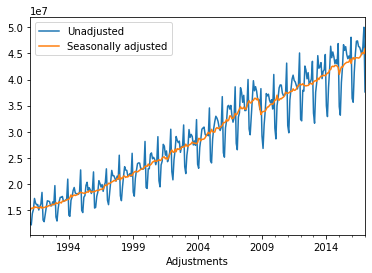

In [4]:
from pandas.tseries.offsets import MonthEnd

df["Adjustments"] = pd.to_datetime(df["Adjustments"]) + MonthEnd(1)
#말일을 붙여줌. 근데 굳이 그럴 필요 있나? to_datetime 하면 1일이 붙여짐
df = df.set_index('Adjustments') #날짜 칼럼을 index(행)로 바꾸어 줌
print(df.head())
df.plot() #날짜를 x축으로 해서 그릴 수 있음

## train, test split
- 2011.1.1 기준으로 구분
- 필요한 건 Unadjusted 열이므로, 그것만 남김

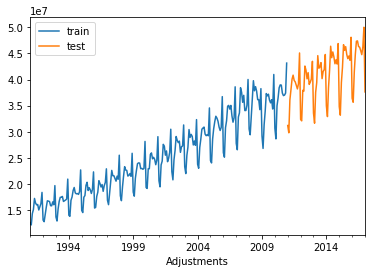

In [5]:
split_date = pd.Timestamp('01-01-2011')
# 근데 이러면 만약 2011.1.1 데이터가 있을 경우, train, test 둘다 해당 날짜 데이터를 가짐
train = df.loc[:split_date, ['Unadjusted']]
test = df.loc[split_date:, ['Unadjusted']]

ax = train.plot()
test.plot(ax = ax)
plt.legend(['train', 'test'])

In [6]:
# 날짜 구분된 것 확인
print(train.tail())
print(test.head())

             Unadjusted
Adjustments            
2010-08-31     37395330
2010-09-30     36923390
2010-10-31     37014326
2010-11-30     37408825
2010-12-31     43147947
             Unadjusted
Adjustments            
2011-01-31     31191594
2011-02-28     29797949
2011-03-31     36099866
2011-04-30     38035760
2011-05-31     40046516


In [10]:
# 변수 Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
train_sc = sc.fit_transform(train) #fit 후 transform
test_sc = sc.transform(test) #이미 train을 통해 scaling 한 값을 쓰는 듯

print(train_sc[:4])
print(test_sc[:4])

[[0.01402033]
 [0.        ]
 [0.0704258 ]
 [0.09531795]]
[[0.61423187]
 [0.56926634]
 [0.77259579]
 [0.83505683]]


In [11]:
# 데이터 편집을 위해 DataFrame으로 변환
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index = train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)

In [12]:
# 이전 데이터를 통해 학습하기 위해, lag(시차) 값 필요. df.shift() 사용
for s in range(1, 13): # 1 ~ 12시차 데이터 생성
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)
    
train_sc_df.head()

,Scaled,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Adjustments,,,,,,,,,,,,,
1991-01-31,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-02-28,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-03-31,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-04-30,0.095318,0.070426,0.000000,0.01402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-05-31,0.163628,0.095318,0.070426,0.00000,0.01402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
#train
#1. dropna() -> 모든 null 제거
#2. drop() -> Scaled '열'(axis=1)만 제거
X_train = train_sc_df.dropna().drop('Scaled', axis=1)
#test
#1. dropna() -> 모든 null 제거
#2. Scaled 열만 남김
y_train = train_sc_df.dropna()[['Scaled']] #여기서 싱글 인덱스(그냥 ['Scaled'] 하면) Series가 나옴

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

X_train.head()

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Adjustments,,,,,,,,,,,,
1992-01-31,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020
1992-02-29,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000
1992-03-31,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426
1992-04-30,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318
1992-05-31,0.109831,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628


In [14]:
y_train.head()

,Scaled
Adjustments,
1992-01-31,0.030027
1992-02-29,0.019993
1992-03-31,0.065964
1992-04-30,0.109831
1992-05-31,0.149130


In [15]:
# 다시 이걸 ndarray로 변환(딥러닝 모델에 넣기 위해서)
X_train_val = X_train.values
X_test_val = X_test.values

y_train_val = y_train.values
y_test_val = y_test.values
print(X_train_val.shape)
print(X_train_val[:5])
print(y_train_val.shape)
print(y_train_val[:5])
print(X_test_val.shape)
print(y_test_val.shape)

(228, 12)
[[0.20091289 0.13173822 0.11139526 0.09230917 0.12617398 0.12395846
  0.13514108 0.16362761 0.09531795 0.0704258  0.         0.01402033]
 [0.03002688 0.20091289 0.13173822 0.11139526 0.09230917 0.12617398
  0.12395846 0.13514108 0.16362761 0.09531795 0.0704258  0.        ]
 [0.01999285 0.03002688 0.20091289 0.13173822 0.11139526 0.09230917
  0.12617398 0.12395846 0.13514108 0.16362761 0.09531795 0.0704258 ]
 [0.06596369 0.01999285 0.03002688 0.20091289 0.13173822 0.11139526
  0.09230917 0.12617398 0.12395846 0.13514108 0.16362761 0.09531795]
 [0.10983126 0.06596369 0.01999285 0.03002688 0.20091289 0.13173822
  0.11139526 0.09230917 0.12617398 0.12395846 0.13514108 0.16362761]]
(228, 1)
[[0.03002688]
 [0.01999285]
 [0.06596369]
 [0.10983126]
 [0.14912986]]
(61, 12)
(61, 1)


In [17]:
# keras RNN 계열 모델 -> 3차원 데이터 형식(size, timestep, feature) 형태로 reshape
# '시간'이라는 개념 때문에 한 차원 늘어남
X_train_t = X_train_val.reshape(X_train_val.shape[0], 12, 1) #(228, 12) -> (228, 12, 1)
X_test_t = X_test_val.reshape(X_test_val.shape[0], 12, 1)
print("최종 data")
print(X_train_t.shape)
print(X_train_t[:5])
print(y_train_val[:5])

최종 data
(228, 12, 1)
[[[0.20091289]
  [0.13173822]
  [0.11139526]
  [0.09230917]
  [0.12617398]
  [0.12395846]
  [0.13514108]
  [0.16362761]
  [0.09531795]
  [0.0704258 ]
  [0.        ]
  [0.01402033]]

 [[0.03002688]
  [0.20091289]
  [0.13173822]
  [0.11139526]
  [0.09230917]
  [0.12617398]
  [0.12395846]
  [0.13514108]
  [0.16362761]
  [0.09531795]
  [0.0704258 ]
  [0.        ]]

 [[0.01999285]
  [0.03002688]
  [0.20091289]
  [0.13173822]
  [0.11139526]
  [0.09230917]
  [0.12617398]
  [0.12395846]
  [0.13514108]
  [0.16362761]
  [0.09531795]
  [0.0704258 ]]

 [[0.06596369]
  [0.01999285]
  [0.03002688]
  [0.20091289]
  [0.13173822]
  [0.11139526]
  [0.09230917]
  [0.12617398]
  [0.12395846]
  [0.13514108]
  [0.16362761]
  [0.09531795]]

 [[0.10983126]
  [0.06596369]
  [0.01999285]
  [0.03002688]
  [0.20091289]
  [0.13173822]
  [0.11139526]
  [0.09230917]
  [0.12617398]
  [0.12395846]
  [0.13514108]
  [0.16362761]]]
[[0.03002688]
 [0.01999285]
 [0.06596369]
 [0.10983126]
 [0.14912986]

## LSTM 모델 만들기
- input_shape = (timestep, feature)
- 예측하고자 하는 target 개수는 1개 -> Dense(1)
- 출력값은 연속형 변수 -> loss function은 MSE
- optimizer는 Adam

In [47]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD

K.clear_session()
model = Sequential()
model.add(LSTM(100, input_shape=(12,1))) #20은 memory cell 개수. hyperparameter
model.add(Dense(1)) # n_output = 1
model.compile(loss = "mean_squared_error", optimizer='adam')
# optimizer -> sgd, adagrad 등 가능

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [48]:
# 모델 Fitting
# EarlyStopping -> 멈추는 loss가 몇이지?
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

# model.fit(X_train_t, y_train_val, epochs=100, batch_size=30, verbose=0,
#          callbacks=[early_stop], validation_data=(X_test_t, y_test))
model.fit(X_train_t, y_train_val, epochs=100, batch_size=30, verbose=0,
          validation_data=(X_test_t, y_test_val))

In [49]:
score = model.evaluate(X_test_t, y_test_val, verbose=0)
print(model.metrics_names)
print("test score:", score) #test set의 loss = 0.001

['loss']
test score: 0.0014839433114517664


In [50]:
# test set에 적용하기
X_test_t[0]

array([[1.06265011],
       [0.87180554],
       [0.84048091],
       [0.86220767],
       [0.88363094],
       [0.89302107],
       [0.92552046],
       [0.89993326],
       [0.83505683],
       [0.77259579],
       [0.56926634],
       [0.61423187]])

In [51]:
y_pred = model.predict(X_test_t)
print(y_pred[:5])
print(y_test_val[:5])

[[0.6923122 ]
 [0.64970857]
 [0.8081955 ]
 [0.8621499 ]
 [0.9198128 ]]
[[0.65198848]
 [0.6431242 ]
 [0.83176496]
 [0.82666946]
 [0.98182284]]


In [52]:
# y_pred와 y_test 비교
y_pred_final = y_pred.reshape(-1, 1).flatten()
y_test_final = y_test_val.flatten()

pred_and_test = pd.DataFrame({"pred":pd.Series(y_pred_final), "test":pd.Series(y_test_final)})
pred_and_test.index = y_test.index
pred_and_test.head()

,pred,test
Adjustments,,
2012-01-31,0.692312,0.651988
2012-02-29,0.649709,0.643124
2012-03-31,0.808195,0.831765
2012-04-30,0.862150,0.826669
2012-05-31,0.919813,0.981823


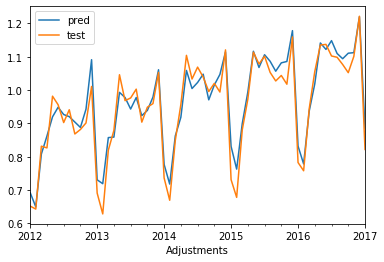

In [53]:
pred_and_test.plot()

## 이번엔 계절성 조정한 거(seasonally adjusted)로 해보기

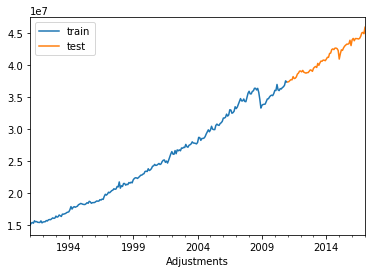

In [54]:
split_date = pd.Timestamp('01-01-2011')
train = df.loc[:split_date, ['Seasonally adjusted']]
test = df.loc[split_date:, ['Seasonally adjusted']]

ax = train.plot()
test.plot(ax = ax)
plt.legend(['train', 'test'])

In [55]:
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

print(train_sc[:4])
print(test_sc[:4])

[[0.        ]
 [0.01231948]
 [0.01715534]
 [0.01182367]]
[[0.99220226]
 [0.9942282 ]
 [1.00217993]
 [1.00831276]]


In [56]:
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index = train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)
train_sc_df.head()

,Scaled
Adjustments,
1991-01-31,0.000000
1991-02-28,0.012319
1991-03-31,0.017155
1991-04-30,0.011824
1991-05-31,0.028800


In [57]:
for s in range(1, 13): # 1 ~ 12시차 데이터 생성
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)

# null 인 데이터 제거
X_train = train_sc_df.dropna().drop('Scaled', axis=1)
y_train = train_sc_df.dropna()[['Scaled']]
X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

# 모델에 넣을 수 있게 변환
X_train_val = X_train.values
X_test_val = X_test.values
y_train_val = y_train.values
y_test_val = y_test.values

# 
X_train_t = X_train_val.reshape(X_train_val.shape[0], 12, 1) #(228, 12) -> (228, 12, 1)
X_test_t = X_test_val.reshape(X_test_val.shape[0], 12, 1)

In [78]:
# LSTM 모델 만들기
# adam optimizer가 가장 잘 예측함!! (그나마)
K.clear_session()
model = Sequential()
model.add(LSTM(100, input_shape=(12,1))) #100은 memory cell 개수. hyperparameter
model.add(Dense(1)) # n_output = 1
model.compile(loss = "mean_squared_error", optimizer='adam')
# optimizer = adagrad, sgd(stochastic gradient descent) 등
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [79]:
# 모델 Fitting
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

model.fit(X_train_t, y_train_val, epochs=100, batch_size=30, verbose=0,
          validation_data=(X_test_t, y_test_val))

In [80]:
score = model.evaluate(X_test_t, y_test, verbose=0)
print(model.metrics_names)
print("test score:", score) # 0.001(adam 기준)

['loss']
test score: 0.001623855785420928


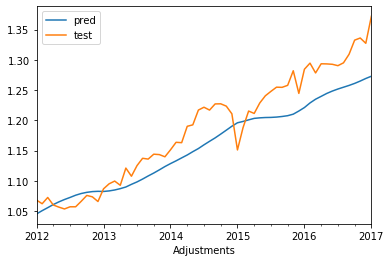

In [81]:
y_pred = model.predict(X_test_t)
y_pred_final = y_pred.reshape(-1, 1).flatten()
y_test_final = y_test_val.flatten()

pred_and_test = pd.DataFrame({"pred":pd.Series(y_pred_final), "test":pd.Series(y_test_final)})
pred_and_test.index = y_test.index
pred_and_test.plot()
# pred가 test를 잘 따라가진 못함
# 근데 1000번 학습하면 오히려 결과 안 좋았음(loss도 0.001보다 큰 0.05)

In [82]:
error = (pred_and_test['pred'] - pred_and_test['test']) ** 2
mse = error.sum() / len(pred_and_test)
mse

0.0016238558148437782